1. **Реализация разделенной стратегии:**
   - Реализовал алгоритм управления МК с разделенной стратегией для среды `Acrobot` из библиотеки OpenAI Gym.
   - Использовал случайную поведенческую стратегию для сбора данных и обучения целевой стратегии.

2. **Оптимизация параметров:**
   - Провел эксперименты с различными значениями параметров (например, коэффициент обесценивания `gamma`, количество эпизодов `n_episode`, ε для ε-жадной стратегии).
   - Определил оптимальные значения параметров, которые приводят к наилучшим результатам в обучении.

3. **Сравнение стратегий:**
   - Сравнил оптимальную стратегию, полученную с использованием разделенной стратегии, с оптимальной стратегией, полученной с использованием ε-жадной стратегии.
   - Проанализировал, какая стратегия дает лучшие результаты в среде `Acrobot`.

4. **Визуализация результатов:**
   - Визуализировал Q-функцию и стратегию для среды `Acrobot`.
   - Построил графики, чтобы наглядно представить результаты.

# Установка

In [ ]:
!pip install --upgrade gym pyvirtualdisplay ipykernel > /dev/null 2>&1

# Импорт

In [ ]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

env = gym.make("Acrobot-v1")
episodes = 5_000 # Чтобы выполнение было достаточно быстрым

# Рандомная поведенческая стратегия

In [ ]:
# Определение функции-обертки, которая выполняет один эпизод, следуя заданной стратегии, и возвращает полное вознаграждение
def simulate_episode(env, policy):
    state, _ = env.reset()

    while True:
        s_i0  = np.digitize(state[0], th1_cos)
        s_i1  = np.digitize(state[1], th1_sin)
        s_i2  = np.digitize(state[2], th2_cos)
        s_i3  = np.digitize(state[3], th2_sin)
        s_i4  = np.digitize(state[4], th1_w)
        s_i5  = np.digitize(state[5], th2_w)

        action = policy[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5]
        state, reward, done, truncated, info = env.step(action)
        if done or truncated:
            return reward

In [ ]:
# Определение поведенческой стратегии, которая случайным образом с одинаковой вероятностью выбирает действия
def gen_random_policy(n_action):
    """
    Генерирует случайную стратегию с равномерным распределением вероятностей для каждого действия
    @param n_action: количество возможных действий
    @return: функция стратегии, которая возвращает вероятности действий для любого состояния
    """
    probs = torch.ones(n_action) / n_action  # Равномерное распределение вероятностей
    def policy_function(state):
        return probs  # Возвращает одинаковые вероятности для всех состояний
    return policy_function

Episode: 0, Best Reward: -500.0, Mean Rewards -500.0
Episode: 500, Best Reward: -273.0, Mean Rewards -497.3
Episode: 1000, Best Reward: -273.0, Mean Rewards -497.2
Episode: 1500, Best Reward: -273.0, Mean Rewards -498.2
Episode: 2000, Best Reward: -273.0, Mean Rewards -500.0
Episode: 2500, Best Reward: -222.0, Mean Rewards -499.1
Episode: 3000, Best Reward: -222.0, Mean Rewards -500.0
Episode: 3500, Best Reward: -222.0, Mean Rewards -500.0
Episode: 4000, Best Reward: -222.0, Mean Rewards -499.9
Episode: 4500, Best Reward: -222.0, Mean Rewards -499.3


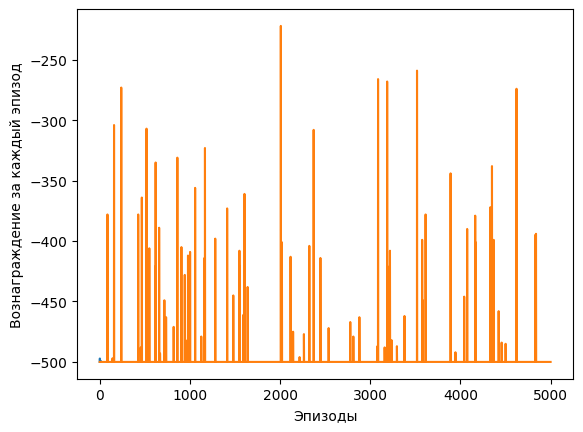

In [ ]:
def Run_Episode(Q, env, gamma, random_policy):
  state = env.reset()[0]      # Исходное положение

  # Преобразование непрерывного состояния в дискретное состояние
  s_i0  = np.digitize(state[0], th1_cos)
  s_i1  = np.digitize(state[1], th1_sin)
  s_i2  = np.digitize(state[2], th2_cos)
  s_i3  = np.digitize(state[3], th2_sin)
  s_i4  = np.digitize(state[4], th1_w)
  s_i5  = np.digitize(state[5], th2_w)

  rewards=0                   # награды, полученные за эпизод

  # Episode
  while True:

      # Выберите случайное действие
      probs = random_policy(state)
      action = torch.multinomial(probs, 1).item()

      # Выполнение
      new_state,reward,done,truncated,info = env.step(action)

      # Преобразование непрерывного состояния в дискретное пространство
      ns_i0  = np.digitize(new_state[0], th1_cos)
      ns_i1  = np.digitize(new_state[1], th1_sin)
      ns_i2  = np.digitize(new_state[2], th2_cos)
      ns_i3  = np.digitize(new_state[3], th2_sin)
      ns_i4  = np.digitize(new_state[4], th1_w)
      ns_i5  = np.digitize(new_state[5], th2_w)

      # Обновление Q-функции

      Q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5][action] += reward + \
          gamma * torch.max(Q[ns_i0, ns_i1, ns_i2, ns_i3, ns_i4, ns_i5]) - \
          Q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5][action]


      # Set state to new state
      state = new_state
      s_i0 = ns_i0
      s_i1 = ns_i1
      s_i2 = ns_i2
      s_i3 = ns_i3
      s_i4 = ns_i4
      s_i5 = ns_i5

      # Collect rewards
      rewards+=reward

      if done or truncated:
          return Q, rewards






def run(env, random_policy, gamma):


    # инициализировать таблицу q массивом 15x15x15x15x15x15x3. 16 = деление 15 плюс 1 дополнительный кусочек
    Q = defaultdict(lambda: torch.zeros(env.action_space.n))  # создаем словарь для хранения Q-значений


    best_reward = -999999        # отслеживать лучшую награду
    rewards_per_episode = []     # список для хранения наград за каждый эпизод
    mean_rewards = []

    for episod in range(episodes):
        # Запуск эпизода
        Q, rewards = Run_Episode(Q, env, gamma, random_policy)

        if rewards>best_reward:
            best_reward = rewards



        # Сохраняем награды за эпизод
        rewards_per_episode.append(rewards)

        # Print stats
        if  episod%500==0:
            # Среднее вознаграждение за последние 100 эпизодов
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {episod}, Best Reward: {best_reward:0.1f}, Mean Rewards {mean_reward:0.1f}')


            # Среднее вознаграждение за эпизоды n-100.
            mean_rewards.append(mean_reward)

        # Stop, if solved
        if best_reward>env.spec.reward_threshold or episod == episodes-1:
            plt.xlabel('Эпизоды')
            plt.ylabel('Среднее полное вознаграждение')
            plt.plot(mean_rewards)
            plt.xlabel('Эпизоды')
            plt.ylabel('Вознаграждение за каждый эпизод')
            plt.plot(rewards_per_episode)
            break


    env.close()

    return Q


divisions = 15
gamma = 0.9
# Разделите непрерывное пространство наблюдения на дискретные сегменты.
th1_cos  = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
th1_sin  = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
th2_cos  = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
th2_sin  = np.linspace(env.observation_space.low[3], env.observation_space.high[3], divisions)
th1_w    = np.linspace(env.observation_space.low[4], env.observation_space.high[4], divisions)
th2_w    = np.linspace(env.observation_space.low[5], env.observation_space.high[5], divisions)

# Создание случайной стратегии для текущей среды
random_policy = gen_random_policy(env.action_space.n)


Q_random =  run(env, random_policy, gamma)

# Формирование оптимальной политики на основе Q-значений
policy_random = {}
for state, actions in Q_random.items():
    policy_random[state] = torch.argmax(actions).item()

# ε-жадная стратегия

Episode: 0, Best Reward: -448.0, Mean Rewards -448.0
Episode: 500, Best Reward: -293.0, Mean Rewards -490.7
Episode: 1000, Best Reward: -218.0, Mean Rewards -489.2
Episode: 1500, Best Reward: -218.0, Mean Rewards -496.8
Episode: 2000, Best Reward: -218.0, Mean Rewards -488.6
Episode: 2500, Best Reward: -218.0, Mean Rewards -490.9
Episode: 3000, Best Reward: -198.0, Mean Rewards -494.1
Episode: 3500, Best Reward: -198.0, Mean Rewards -498.1
Episode: 4000, Best Reward: -198.0, Mean Rewards -499.4
Episode: 4500, Best Reward: -198.0, Mean Rewards -491.1


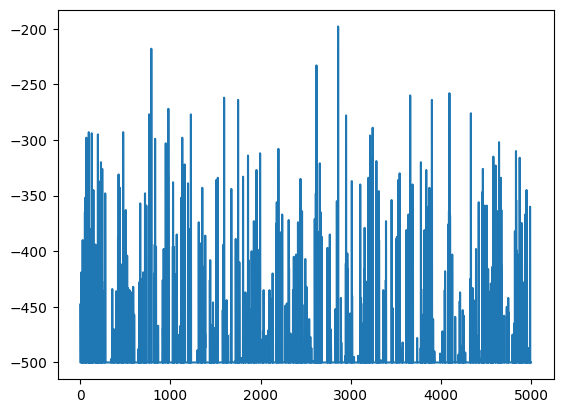

In [ ]:
# Функция, которая выполняет один эпизод, следуя ε-жадной стратегии
def run_episode(env, Q, epsilon, n_action):
    """
    Выполняет эпизод, следуя ε-жадной стратегии
    @param env: имя окружающей среды OpenAI Gym
    @param Q: Q-функция
    @param epsilon: компромисс между исследованием и использованием
    @param n_action: пространство действий
    @return: результирующие состояния, действия и вознаграждения для всего эпизода
    """
    state = env.reset()[0] # сброс среды и получение начального состояния

    # Преобразование непрерывного состояния в дискретное пространство
    s_i0  = np.digitize(state[0], th1_cos)
    s_i1  = np.digitize(state[1], th1_sin)
    s_i2  = np.digitize(state[2], th2_cos)
    s_i3  = np.digitize(state[3], th2_sin)
    s_i4  = np.digitize(state[4], th1_w)
    s_i5  = np.digitize(state[5], th2_w)

    rewards = 0 # награды, полученные за эпизод

    # rewards = [] # список для хранения вознаграждений
    # actions = [] # список для хранения действий
    # states = []  # список для хранения состояний
    while True:
        # Если случайное число меньше эпсилон, выбираем рандомно
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        # Если нет, выбираем лучшее действие
        else:
            action = torch.argmax(Q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5])

        # Выполнение действия в среде и получение нового состояния, вознаграждения и флага завершения
        new_state, reward, done, truncated, info = env.step(action)
        # Преобразование непрерывного состояния в дискретное пространство
        ns_i0  = np.digitize(new_state[0], th1_cos)
        ns_i1  = np.digitize(new_state[1], th1_sin)
        ns_i2  = np.digitize(new_state[2], th2_cos)
        ns_i3  = np.digitize(new_state[3], th2_sin)
        ns_i4  = np.digitize(new_state[4], th1_w)
        ns_i5  = np.digitize(new_state[5], th2_w)

        # Обновление q-функции
        Q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5][action] += reward + \
          gamma * torch.max(Q[ns_i0, ns_i1, ns_i2, ns_i3, ns_i4, ns_i5]) - \
          Q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5][action]

        # Обновляем состояние
        state = new_state
        s_i0 = ns_i0
        s_i1 = ns_i1
        s_i2 = ns_i2
        s_i3 = ns_i3
        s_i4 = ns_i4
        s_i5 = ns_i5

        # Посчитываем награды
        rewards+=reward

        # rewards.append(reward)

        if done or truncated:
            return Q, rewards

# Реализация управления МК с ε-жадной единой стратегией
from collections import defaultdict
mean_rewards = []
def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon):
    """
    Строит оптимальную ε-жадную стратегию методом управления МК с единой стратегией
    @param env: имя окружающей среды OpenAI Gym
    @param gamma: коэффициент обесценивания
    @param n_episode: количество эпизодов
    @param epsilon: компромисс между исследованием и использованием
    @return: оптимальные Q-функция и стратегия
    """
    # Инициализация Q-таблицы массивом 15x15x15x15x15x15x3. 16 = деление 15 плюс 1 дополнительный кусочек
    Q = defaultdict(lambda: torch.zeros(env.action_space.n))  # создаем словарь для хранения Q-значений

    best_reward = -999999        # отслеживать лучшую награду
    rewards_per_episode = []     # список для хранения наград за каждый эпизод
    # i = 0                        # счетчик эпизодов



    n_action = env.action_space.n  # количество возможных действий

    for episod in range(n_episode):
    # while True:
        Q, rewards = run_episode(env, Q, epsilon, n_action)  # Выполнение эпизода

        # Выборка лучшей награды
        if rewards>best_reward:
            best_reward = rewards

        # Сохраняем награды за эпизод
        rewards_per_episode.append(rewards)

        if  episod%500==0:
            # Среднее вознаграждение за последние 100 эпизодов
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {episod}, Best Reward: {best_reward:0.1f}, Mean Rewards {mean_reward:0.1f}')

            # Среднее вознаграждение за эпизоды n-100.
            mean_rewards.append(mean_reward)

        # i +=1

        if best_reward>env.spec.reward_threshold or episod == n_episode-1:
        # if episode == 999:
            plt.plot(rewards_per_episode)
            break
    return Q



# Задание параметров
gamma = 1  # коэффициент обесценивания
# n_episode = 500000  # количество эпизодов
epsilon = 0.4  # компромисс между исследованием и использованием
divisions = 15 # используется для преобразования непрерывного пространства состояний в дискретное пространство

# Делим непрерывное пространство наблюдения на дискретные сегменты.
th1_cos  = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
th1_sin  = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
th2_cos  = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
th2_sin  = np.linspace(env.observation_space.low[3], env.observation_space.high[3], divisions)
th1_w    = np.linspace(env.observation_space.low[4], env.observation_space.high[4], divisions)
th2_w    = np.linspace(env.observation_space.low[5], env.observation_space.high[5], divisions)


# Выполнение алгоритма управления МК с ε-жадной стратегией для нахождения оптимальных Q-функции и стратегии
optimal_Q  = mc_control_epsilon_greedy(env, gamma, episodes, epsilon)

# Формирование оптимальной политики на основе Q-значений
optimal_policy = {}
for state, actions in optimal_Q.items():
  optimal_policy[state] = torch.argmax(actions).item()

# Снова сымитируем 100 000 эпизодов игры в блэкджек с оптимальной стратегией и подсчитаем вероятности выигрыша и проигрыша
n_episode = 10_000
n_win_optimal = 0
n_lose_optimal = 0


# Выводы
Коэффициент обесценивания повышает устойчивость алгоритма, поскольку отдаленные по времени вознаграждения учитываются лишь частично. стратегии заинтересованы в поиске новых состояний, для дальнейшей оценки стратегии, так как качество растет по мере увеличения коэффициента обесценивания.

Для данной задачи необходимо провести больше число эпизодов, при большом количестве эпизодов стратегии могут победить в игре используя 120 шагов.

Жадная стратегия в данной игре показывает средние лучшие результаты, благодаря маленькому значению эпсилон, которая позволяет несколько раз использовать максимально полезное действие